In [31]:
from typing import List
from functools import wraps

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import yfinance as yf
import datetime as dt

jtplot.style(figsize=(15, 9))

In [2]:
# tickers = ['GLD', 'GDX', 'AAPL', 'SPY']
# # tickers = ['MSFT', 'NVDA', 'AMD', 'META']
# d_start = dt.datetime(2010, 1, 1)
# d_final = dt.datetime(2020, 12, 31)
#  period = '1d'

# df = yf.download(tickers, start=d_start, end=d_final, period=period, auto_adjust=True)
# df.to_csv(f"../../../data/bt/{'_'.join(tickers)}__{period.upper()}.csv")

In [2]:
import os

DATA_PATH = '../../data/bt/'

def read_csv_bt(csv:str)->pd.DataFrame:
    file_path = f"{DATA_PATH}{csv}"
    tickers, _ = csv.split('__')
    if len(tickers)>1:
        return pd.read_csv(file_path, parse_dates=True, header=[0, 1], index_col=0)['Close']
    else:
        return pd.read_csv(file_path, parse_dates=True, index_col=0)['Close']

def get_backtest_data()->List[list]:
    bt_files = os.listdir(DATA_PATH)
    csv_files = []
    for csv in bt_files:
        try:
            tickers, period = csv.split('__')
            df = read_csv_bt(csv) # send to some dict with data???
            csv_files.append({
                'csv': csv,
                'tickers': list(map(str.upper, tickers.split('_'))),
                'period': period.replace('.csv', ''),
                'start': df.iloc[0].name.strftime('%d/%m/%Y'),
                'end': df.iloc[-1].name.strftime('%d/%m/%Y')
            })
        except:
            continue
    return csv_files


## Strategies for testing

In [46]:
class Strategy:
    def __init__(self):
        pass
    
    def set_data(self, ticker:str, data:pd.DataFrame):
        self.data = data.copy()
        self.data['returns'] = np.log(self.data[ticker] / self.data[ticker].shift(1))
        self.ticker = ticker
        self.strategy = []
        self.drawdown = []
    
    def get_result(self):
        strategy_result = self.data[self.strategy+['returns']].sum().apply(np.exp)
        drawdown_result = self.data[self.drawdown].max()
        result = pd.concat([strategy_result, drawdown_result]).to_frame()
        result.rename(columns={0: self.ticker}, inplace=True)
        
        return result


In [47]:
class SMA(Strategy):
    def __init__(self, sma1:List[int]=[42], sma2:List[int]=[252]):
        self.sma1 = sma1
        self.sma2 = sma2
    
    def run_strategy(self):
        for s1, s2 in zip(self.sma1, self.sma2):
            self.data[f'SMA1_{s1}'] = self.data[self.ticker].rolling(s1).mean()
            self.data[f'SMA2_{s2}'] = self.data[self.ticker].rolling(s2).mean()
            self.data.dropna(inplace=True)

            self.data[f'position_{s1}_{s2}'] = np.where(self.data[f'SMA1_{s1}'] > self.data[f'SMA2_{s2}'], 1, -1)
            self.data[f'strategy_{s1}_{s2}'] = self.data[f'position_{s1}_{s2}'].shift(1) * self.data['returns']
            self.strategy.append(f'strategy_{s1}_{s2}')

            self.data[f'cumret_{s1}_{s2}'] = self.data[f'strategy_{s1}_{s2}'].cumsum()#.apply(np.exp)
            self.data[f'cummax_{s1}_{s2}'] = self.data[f'cumret_{s1}_{s2}'].cummax()
            self.data[f'drawdown_{s1}_{s2}'] = self.data[f'cummax_{s1}_{s2}'] - self.data[f'cumret_{s1}_{s2}']
            self.drawdown.append(f'drawdown_{s1}_{s2}')

        result = self.get_result()
    
        return result, self.data.copy()
    

In [35]:
class MOM(Strategy):
    def __init__(self, moms:List[int]=[1]):
        self.moms = moms
    
    def run_strategy(self):
        for mom in self.moms:
            self.data[f'MOM_{mom}'] = self.data[self.ticker].rolling(mom).mean()
            self.data.dropna(inplace=True)

            self.data[f'position_{mom}'] = np.sign(self.data['returns'].rolling(mom).mean())
            self.data[f'strategy_{mom}'] = self.data[f'position_{mom}'].shift(1) * self.data['returns']
            self.strategy.append(f'strategy_{mom}')

            self.data[f'cumret_{mom}'] = self.data[f'strategy_{mom}'].cumsum().apply(np.exp)
            self.data[f'cummax_{mom}'] = self.data[f'cumret_{mom}'].cummax()
            self.data[f'drawdown_{mom}'] = self.data[f'cummax_{mom}'] - self.data[f'cumret_{mom}']
            self.drawdown.append(f'drawdown_{mom}')

        result = self.get_result()
    
        return result, self.data.copy()


In [36]:
class MeanRe(Strategy):
    def __init__(self, sma:List[int]=[25], threshold:float=3.5):
        self.sma = sma
        self.threshold = threshold
        
    def run_strategy(self):
        for s in self.sma:
            self.data['SMA'] = self.data[self.ticker].rolling(s).mean()
            self.data['distance'] = self.data[self.ticker] - self.data['SMA']
            self.data['distance'].dropna(inplace=True)
            
            self.data[f'position_{s}'] = np.where(self.data['distance'] > self.threshold,
                                                  -1, np.nan)  
            self.data[f'position_{s}'] = np.where(self.data['distance'] < -self.threshold,
                                                  1, self.data[f'position_{s}'])  
            self.data[f'position_{s}'] = np.where(self.data['distance'] * self.data['distance'].shift(1) < 0,
                                                  0, self.data[f'position_{s}'])  
            self.data[f'position_{s}'] = self.data[f'position_{s}'].ffill().fillna(0)
            self.data[f'strategy_{s}'] = self.data[f'position_{s}'].shift(1) * self.data['returns']
            self.strategy.append(f'strategy_{s}')
            
            self.data[f'cumret_{s}'] = self.data[f'strategy_{s}'].cumsum().apply(np.exp)
            self.data[f'cummax_{s}'] = self.data[f'cumret_{s}'].cummax()
            self.data[f'drawdown_{s}'] = self.data[f'cummax_{s}'] - self.data[f'cumret_{s}']
            self.drawdown.append(f'drawdown_{s}')
            
        result = self.get_result()
        
        return result, self.data.copy()
    

In [48]:
def start_backtesting(strategy_cls, *args)->list:
    bt_results_dfs = []
    full_data_dfs = []
    bt_data_files = get_backtest_data()
    for bt in bt_data_files:
        csv, tickers, period, _, _ = bt.values()
        data = read_csv_bt(csv)

        single_ticker_result = []
        full_data_cnt = []
        STRATEGY = get_strategy(strategy_cls, *args)
        for ticker in tickers:
            STRATEGY.set_data(ticker, pd.DataFrame(data[ticker]))
            result, full_data = STRATEGY.run_strategy()
            
            single_ticker_result.append(result)
            full_data_cnt.append(full_data)

        single_ticker_result = pd.concat(single_ticker_result, axis=1)
        single_ticker_result.index.name = period
        bt_results_dfs.append(single_ticker_result)
        full_data_dfs.append(full_data_cnt)
    return bt_results_dfs, full_data_dfs
        
def get_strategy(strategy, *args):
    strategies = dict(
        sma=SMA,
        mom=MOM,
        mean_re=MeanRe,
    )
    return strategies[strategy](*args)


In [49]:
SMA1 = [42, 24, 18, 6]
SMA2 = [252, 180, 64, 22]
result, full_data = start_backtesting('sma', SMA1, SMA2)

In [39]:
len(result), len(full_data)

(4, 4)

In [50]:
result[0]

,GLD,GDX,AAPL,SPY
1D,,,,
strategy_42_252,1.308799,1.065529,6.424632,1.466223
strategy_24_180,1.162980,1.102915,6.462446,1.668211
strategy_18_64,1.611339,0.746799,3.299714,1.804156
strategy_6_22,1.462546,2.269095,5.655584,0.803092
returns,1.107165,0.732320,10.219678,3.437358
drawdown_42_252,0.363091,1.296247,0.924971,0.462444
drawdown_24_180,0.468432,0.736603,0.505001,0.589285
drawdown_18_64,0.247767,1.312998,0.779470,0.309084
drawdown_6_22,0.219895,0.815730,0.464297,0.700200


In [52]:
full_data[0][0]

,GLD,returns,SMA1_42,SMA2_252,position_42_252,strategy_42_252,cumret_42_252,cummax_42_252,drawdown_42_252,SMA1_24,...,cumret_18_64,cummax_18_64,drawdown_18_64,SMA1_6,SMA2_22,position_6_22,strategy_6_22,cumret_6_22,cummax_6_22,drawdown_6_22
Date,,,,,,,,,,,,,,,,,,,,,
2012-01-18,161.600006,0.006830,160.912381,154.237381,1,0.006830,0.152667,0.285680,0.133013,156.362083,...,-0.059075,0.013150,0.072225,160.008334,156.425000,1,NaN,NaN,NaN,NaN
2012-01-19,161.220001,-0.002354,160.667381,154.346508,1,-0.002354,0.150312,0.285680,0.135367,156.477500,...,-0.056721,0.013150,0.069871,160.438334,156.829090,1,-0.002354,-0.002354,-0.002354,0.000000
2012-01-20,162.070007,0.005258,160.547619,154.469008,1,0.005258,0.155571,0.285680,0.130109,156.860000,...,-0.061979,0.013150,0.075129,160.838336,157.140000,1,0.005258,0.002904,0.002904,0.000000
2012-01-23,163.160004,0.006703,160.441429,154.596508,1,0.006703,0.162274,0.285680,0.123406,157.311250,...,-0.068682,0.013150,0.081832,161.301669,157.516819,1,0.006703,0.009607,0.009607,0.000000
2012-01-24,162.009995,-0.007073,160.405952,154.722103,1,-0.007073,0.155201,0.285680,0.130479,157.593750,...,-0.061609,0.013150,0.074759,161.760002,157.745455,1,-0.007073,0.002534,0.009607,0.007073
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-23,175.649994,0.006626,174.893095,166.068134,1,0.006626,0.403343,0.502141,0.098798,172.939166,...,0.436424,0.502583,0.066159,175.683334,172.713181,1,0.006626,0.368575,0.491591,0.123016
2020-12-24,176.350006,0.003977,174.840715,166.202936,1,0.003977,0.407320,0.502141,0.094820,172.988750,...,0.432447,0.502583,0.070136,175.925003,172.900454,1,0.003977,0.372553,0.491591,0.119039
2020-12-28,175.710007,-0.003636,174.761905,166.335396,1,-0.003636,0.403685,0.502141,0.098456,172.989583,...,0.436083,0.502583,0.066501,175.753337,173.178637,1,-0.003636,0.368917,0.491591,0.122674


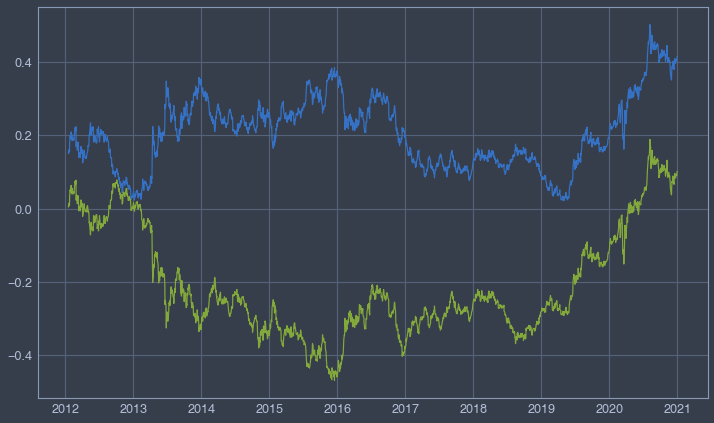

In [51]:
plt.plot(full_data[0][0]['cumret_42_252'])
plt.plot(full_data[0][0]['returns'].cumsum())

In [77]:
start_backtesting('mom', [10])

[                  GLD       GDX       AAPL       SPY
 1D                                                  
 strategy_10  0.995737  0.314059   3.301410  1.175725
 returns      1.586182  0.809055  20.724333  4.027025
 drawdown_10  0.323483  1.662379   1.366986  0.677924,
                   GLD       GDX      AAPL       SPY
 1H                                                 
 strategy_10  1.011674  0.624452  0.577015  0.893413
 returns      1.565266  1.620833  1.586997  1.577566
 drawdown_10  0.159304  0.511475  0.485228  0.169165,
                  MSFT       NVDA        AMD      META
 1D                                                   
 strategy_10  0.565772   0.743711   2.656222  0.325733
 returns      9.193323  32.440119  10.254445  9.184797
 drawdown_10  1.026777   1.593146   8.999155  1.683596,
                  MSFT       NVDA        AMD      META
 1H                                                   
 strategy_10  0.538790   0.885990   2.656222  0.325733
 returns      9.193321

In [10]:
start_backtesting('mean_re')

[                  GLD       GDX       AAPL       SPY
 1D                                                  
 strategy_25  1.095107  3.003503   0.414385  1.214852
 returns      1.618397  0.824147  20.280812  4.083878
 drawdown_25  0.297397  0.844094   0.832532  0.747674,
                   GLD       GDX      AAPL       SPY
 1H                                                 
 strategy_25  0.996823  1.000000  1.092354  1.124085
 returns      1.538725  1.591653  1.594131  1.570848
 drawdown_25  0.114540  0.000000  0.248219  0.156182,
                  MSFT       NVDA       AMD      META
 1D                                                  
 strategy_25  1.706064   1.000000  0.952347  1.240384
 returns      9.196292  30.931284  9.514433  7.111431
 drawdown_25  0.717983   0.000000  0.541103  0.846389,
                  MSFT       NVDA       AMD      META
 1H                                                  
 strategy_25  1.706061   1.000000  0.952347  1.240384
 returns      9.196294  30.931